*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


In [38]:
import nltk
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import umap
import warnings

## NOTE: The embeddings used in this notebook is trained from a dataset resulting from a modified data.py file. The original data.py file only uses the first 5/1701 sentences of the text8 corpus. The modified data.py file uses the entire text8 corpus, but with additional preprocessing steps to reduce the vocabulary size!

- The vocabulary size is reduced to ~18000 words with a minimum count of 50, the same as the gensim training script.
- The skip-gram pairs are generated using a window size of 2 and subsampling based on the word frequency, just like the original implementation of word2vec.

# Part 6: Inspecting and comparing embeddings (28 points)

## Sentence similarity

In [39]:
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text.lower())

sentences = [
    "The feline was resting on the rug.",
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/JackYu_1/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# wrapper class to, given pickle or gensim models, return embedding of a word
# using ModelLoader.get_emb(word)
class ModelLoader:
    def __init__(self, path, model_type):
        self.path = path
        self.model_type = model_type # 'gensim' or 'pickle'
        self.data = None
        self.model = None
        self.embeddings = None
        
        self.load_model()

    def load_model(self):
        # print(f"loading {self.model_type}: {self.path}")
        
        if self.model_type == 'pickle':
            with open(self.path, 'rb') as f:
                self.data = pickle.load(f)

            self.embeddings = self.data['embeddings']
            self.word2idx = self.data['word2idx']
            
        elif self.model_type == 'gensim':
                self.model = KeyedVectors.load(self.path)


    def get_emb(self, word):
        if self.model_type == 'pickle':
            if word in self.word2idx:
                idx = self.word2idx[word]
                return self.embeddings[idx]
            # print(f"failed to find token '{word}'")
            return None
            
        elif self.model_type == 'gensim':
            try:
                return self.model[word]
            except:
                # print(f"failed to find token '{word}'")
                return None


prefix = '/Users/JackYu_1/Desktop/STAT_359/stat359/student/Assignment_2/embeddings/'

models = [
        (f"{prefix}word2vec_embeddings.pkl", "pickle"),
        (f"{prefix}word2vec_gensim_embeddings.pkl", "pickle"),
        (f"{prefix}word2vec-google-news-300.model", "gensim"),
        (f"{prefix}fasttext-wiki-news-subwords-300.model", "gensim")
]

In [41]:
def get_sentence_embedding(sentence, model):
    tokens = tokenize_text(sentence)
    vectors = []
    
    for token in tokens:
        vec = model.get_emb(token)
        if vec is not None:
            vectors.append(vec)

    return np.mean(vectors, axis=0).reshape(1, -1)


def compare_sentences(model, query, sentences):
    query_emb = get_sentence_embedding(query, model)
    
    scores = []
    for sentence in sentences:
        sent_emb = get_sentence_embedding(sentence, model)
        scores.append((cosine_similarity(query_emb, sent_emb)[0][0], sentence))

    return scores

In [42]:
results = {}

for path, model_type in models:
    wrapper = ModelLoader(path, model_type)
    scores_list = compare_sentences(wrapper, query, sentences)

    clean_model_name = os.path.splitext(os.path.basename(path))[0]
    results[clean_model_name] = [item[0] for item in scores_list]

similarities = pd.DataFrame(results, index=sentences)

In [43]:
similarities

,word2vec_embeddings,word2vec_gensim_embeddings,word2vec-google-news-300,fasttext-wiki-news-subwords-300
The feline was resting on the rug.,0.627797,0.473020,0.779382,0.924730
The cat sat on the mat.,0.788211,0.681424,0.736872,0.911408
A dog is playing in the yard.,0.742810,0.572704,0.648278,0.851180
I need to buy groceries today.,0.573771,0.181723,0.371789,0.585846
Canines enjoy outdoor activities.,0.443897,0.081127,0.428147,0.650420
My shopping list includes milk and bread.,0.665758,0.491538,0.496959,0.834956
The weather is beautiful today.,0.581119,0.479713,0.431013,0.809037
Programming requires logical thinking.,0.368837,0.033702,0.297923,0.613466


### My observations:

1. Both the 100-dimensional models trained on the limited Text8 corpus fail to capture the semantic connection between "feline" and "cat". leading them to incorrectly rank the sentence about the dog higher than the relevant feline sentence.

2. My custom PyTorch implementation generally aligns with the Gensim version but performs slightly worse, likely due to my rudimentary hyperparameter tuning and aggressive subsampling compared to the optimized library implementation.

3. The 300-dimensional pretrained models benefit from massive datasets to correctly identify "The feline was resting on the rug" as the most similar sentence, showing how scaling up is beneficial for capturing synonymy.

4. FastText yields the most impressive semantic accuracy (0.92 sentence-wise), but I noticed it assigns consistently higher similarity scores to all sentences, significantly raising the baseline for a "match". It might be due to that FastText could identify subword information, leading to more accurate semantic relationships but also closer embeddings.

## t-SNE & UMAP

In [44]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

words = animals + foods
labels = ['Animal'] * len(animals) + ['Food'] * len(foods)
color_map = {'Animal': 'blue', 'Food': 'red'}

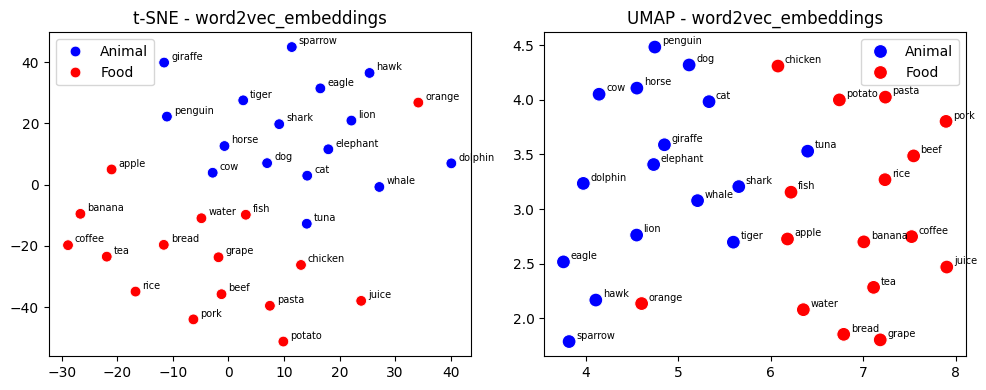

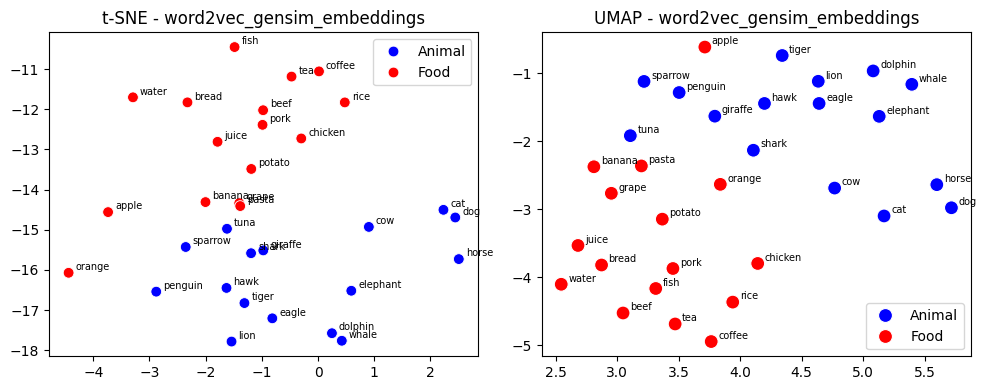

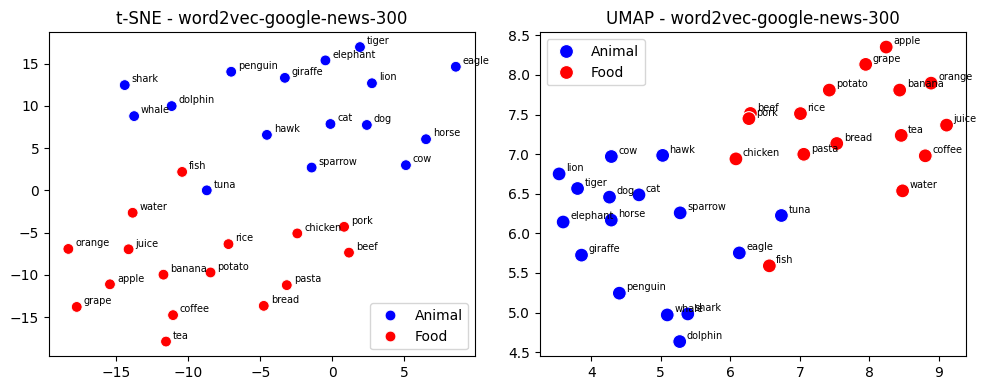

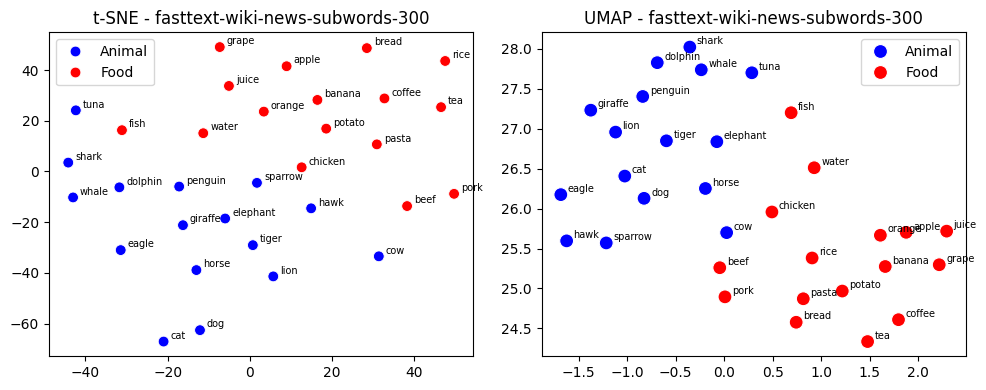

In [45]:
warnings.filterwarnings('ignore')

for path, model_type in models:
    wrapper = ModelLoader(path, model_type)
    embeddings = np.array([wrapper.get_emb(w) for w in words])

    tsne = TSNE(n_components=2, perplexity=12, random_state=67)
    X_tsne = tsne.fit_transform(embeddings)

    reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, random_state=67)
    X_umap = reducer.fit_transform(embeddings)

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    model_name = os.path.splitext(os.path.basename(path))[0]
    
    # tsne
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=color_map, s=60, ax=ax1, legend=True)
    ax1.set_title(f"t-SNE - {model_name}")
    for i, word in enumerate(words):
        ax1.annotate(word, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=7, xytext=(5, 2), textcoords='offset points')

    # umap
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette=color_map, s=100, ax=ax2, legend=True)
    ax2.set_title(f"UMAP - {model_name}")
    for i, word in enumerate(words):
        ax2.annotate(word, (X_umap[i, 0], X_umap[i, 1]), fontsize=7, xytext=(5, 2), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()


### My observations:

1. It is obvious that the two 300-dim embeddings are achieving better category separation than the 100-dim embeddings. Although they do not produce isolated clusters, they are still able to separate the categories. The FastText embeddings is also better than the Word2Vec embeddings, being able to identify how "fish" is closer to the "food" category than "animal".

2. Both of the 100-dim embeddings are making a curious mistake that "apple" or "orange" is significantly closer to "animal" than "food". I couldn't give a good reason why this is happening, but my guess is that they are polysemous words, with "apple" also referring to a tech company and "orange" also referring to a color. This leads to higher noise in the embeddings and leading to the weird mistake.

# Part 7: Short Answer Questions (10 points)

#### Which embeddings performed best at capturing sentence meaning?

- The pretrained FastText and Google News (300-dim embeddings) captured sentence meaning best, as they were the only models to correctly identify "The feline was resting on the rug" as the most similar sentence to the query.

- In contrast, the models trained on the smaller Text8 corpus over-relied on direct word overlaps like "cat" and "mat" or broad topic similarities, causing them to incorrectly rank the sentence about the dog higher than the one about the feline.

#### Were the pretrained embeddings significantly better than your own? Why or why not?

- The 100-dim gensim embeddings were moderately superior to my own PyTorch implementation, while the 300-dim gensim embeddings were even better.

- This performance gap is largely due to the difference in training data size; the gensim implementation streams a larger proportion of data, while the corpus used by the 300-dim gensim embeddings was much larger than the lightweight Text8 corpus. Also, the pre-trained models are trained with better algorithms and more advanced techniques and hyperparameter tuning. The difference could be seen from the sentence similarity results, as well as the better categorization ability of the 300-dim embeddings.

#### What factors might explain the differences in performance?

- Performance differences are primarily driven by the size of the training corpus and the dimensionality of the embeddings, with the 300-dimensional pretrained models capturing far richer semantic relationships than the 100-dimensional local models.

- FastText's inclusion of subword information explains its consistently higher similarity scores and better categorization ability, as it can capture more subtle semantic relationships between words.

- The 300-dim embeddings might also be less noisy than the 100-dim embeddings, as they are trained on a larger corpus. It will definitely handle more edge cases than the 100-dim embeddings, as evident from the categorization visualization.


## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>

- Gemini 3.0 is used for debugging several mistakes in the pytorch training script, as well as coding the complex visualization configurations.
